# The Time Independent Schrödinger Equation

Written by Ben London, Jacob Sunnerberg, Charlie DeLorey  \
Tufts Computation Physics Project 2 \
February 26, 2020

The program below attempts to solve the Time Independent Schrödinger Equation (TISE) for the first several energy levels and is adaptable to many more energy levels, potentials, etc. Solving the TISE was done using different integrators and root finders, and the following are what we have determined to be some of the better options for doing so.

***
Import required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import scipy.integrate as integrate
import scipy.interpolate as interp
from scipy import optimize
import time

import warnings

Set up variables

In [2]:
L = 10
dx = .001
n_steps = L/dx
x = np.linspace(0,L,n_steps)

Define the potential function (this could be any potential function)

In [3]:
# semi-infinite triangular potential
def V(x): 
    if x < 0: 
        return np.Inf
    else :
        return x

Define the TISE

In [4]:
def TISE(y,x,E):
    psi,psi_p = y
    psi_pp = -2*(E - V(x))*psi
    return [psi_p,psi_pp]

Define the function to integrate the TISE over x

In [5]:
def Wave_function(energy):
    E = energy
    sol = odeint(TISE,[0,1],x,args=(E,));
    return sol[-1,0]

***
Using the shooting (aka "wag the dog") method, we can estimate ranges of energy levels where the roots should be. (alternatively this step can be skipped and we can guess reasonable ranges)

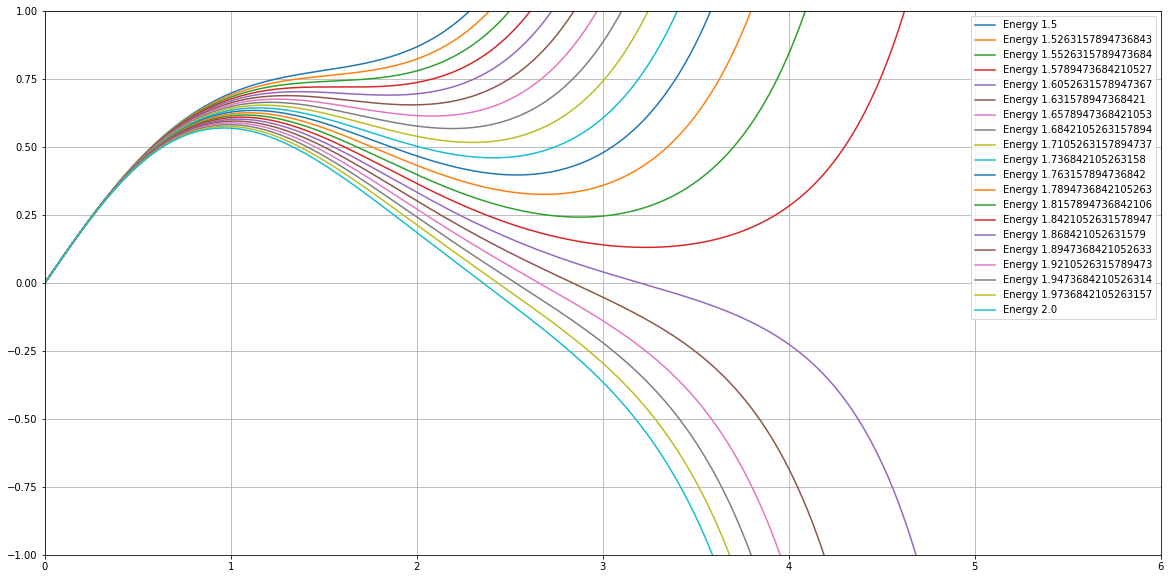

In [6]:
# Shooting Method
EEs = np.linspace(1.5,2,20) # Change range to narrow down proper value

plt.figure(figsize=(20,10))
for E in EEs:
    sol = odeint(TISE,[0,1],x,args=(E,));
    plt.plot(x,sol[:,0],label="Energy "+str(E));
plt.legend()
plt.grid(axis="both")
plt.xlim([0,6])
plt.ylim([-1,1])
plt.show()

***
Based on the shooting method we can estimate the value of all the energy levels. Using brentq, we can then get more exact values for the energy levels based on a range we view above. (if we skip the above step, then we could simple make an educated guess for the energy levels)

In [7]:
print("Energy Levels with odeint method:")
# First energy level
root1 = optimize.brentq(Wave_function, 1.5, 2)
print(root1)

# Second energy level
root2 = optimize.brentq(Wave_function, root1+dx, 4)
print(root2)

# Third energy level
root3 = optimize.brentq(Wave_function, root2+dx, 5)
print(root3)

# Fourth energy level
root4 = optimize.brentq(Wave_function, root3+dx, 6)
print(root4)

# Fifth energy level
root5 = optimize.brentq(Wave_function, root4+dx, 8)
print(root5)

Energy Levels with odeint method:
1.8557570213819359
3.2446076284189065
4.381671241487725
5.386613739677824
7.969397377665319


We can now plot the solution to the TISE for all of the energy levels we have found using odeint.

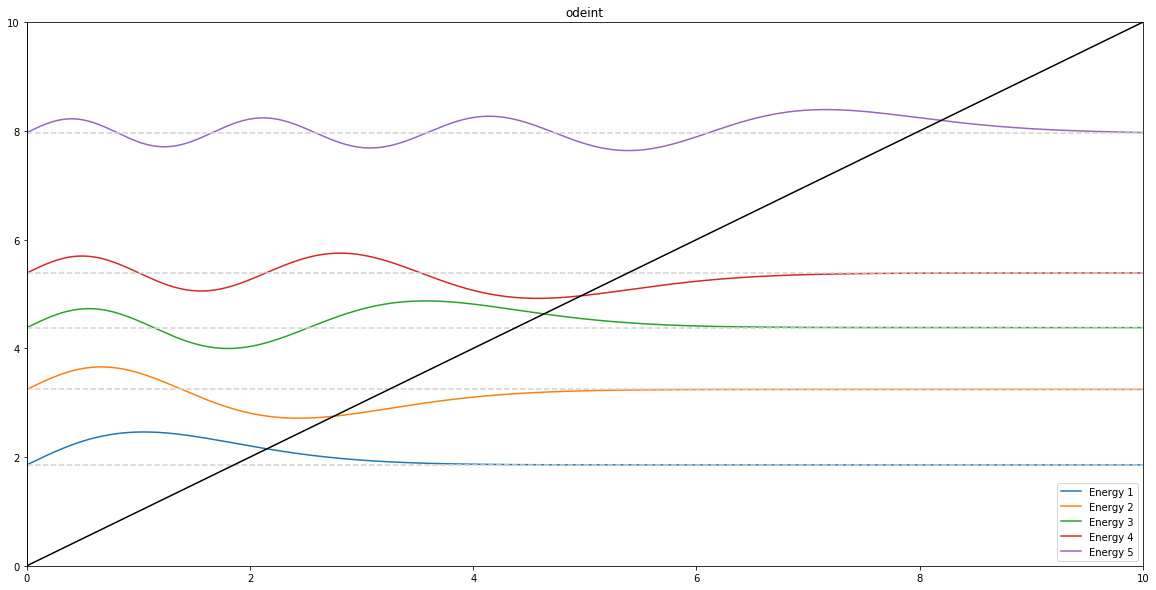

In [8]:
plt.figure(figsize=(20,10))

i = 1 # iterator for which energy level we are on

# Primary loop
for E in [root1,root2, root3,root4,root5]:
    
    sol = odeint(TISE,[0,1],x,args=(E,));
    
    plt.plot(x,E+sol[:,0],label="Energy "+str(i));
    plt.plot([0,x[-1]],[E,E],'--',color="lightgray")
    i+=1

# Make plot pretty
plt.plot([0,L],[0,L],'k')
plt.plot([0,0],[0,2*L],'k')
plt.title("odeint")
plt.legend(loc="lower right")
plt.xlim([0,L])
plt.ylim([0,L])
plt.show()

Plot the energy levels stacked and normalized

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


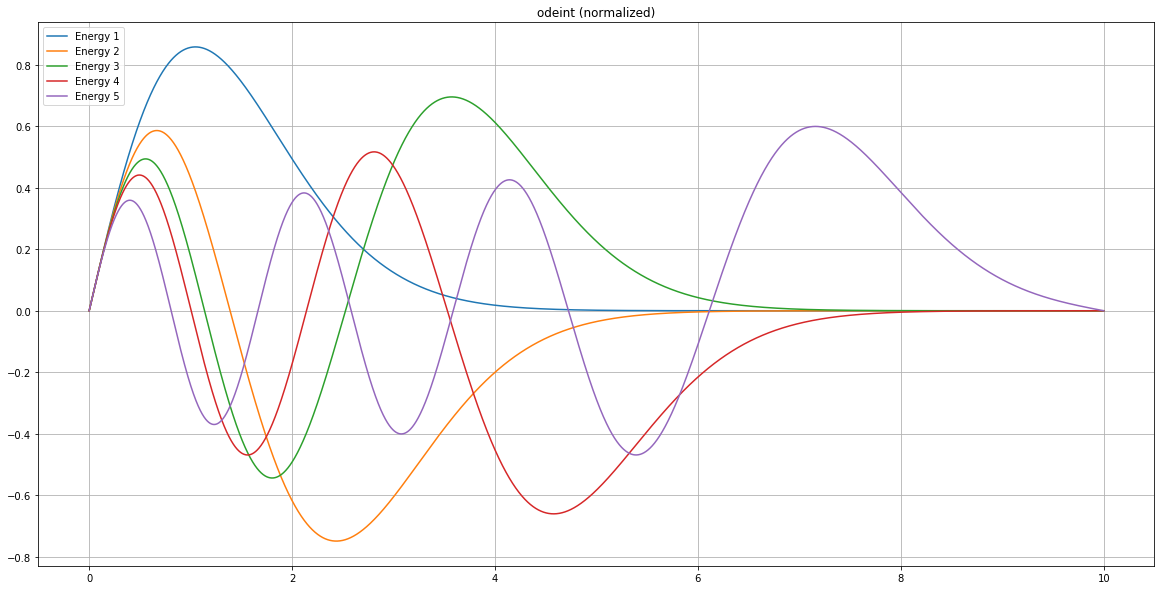

In [9]:
plt.figure(figsize=(20,10))
i = 1
for E in [root1,root2, root3,root4,root5]:
    
    sol = odeint(TISE,[0,1],x,args=(E,));
    
    # Interpolate over the solution found by odeint
    tise_interp = interp.interp1d(x,sol[:,0]**2) 
    
    # Integrate over that interpolated function
    val,err = integrate.quad(tise_interp,0,L)
    
    # Normalize values using the value found above
    sol[:,0] = (1/np.sqrt(val))*sol[:,0]
    
    plt.plot(x,sol[:,0],label="Energy "+str(i));
    i+=1

# Pretty Plot
plt.title("odeint (normalized)")
plt.grid(axis="both")
plt.legend(loc="upper left")
plt.show()

***
An alternative method is the Runge-Kutta method of ODE integration

First we define the functions needed for Runge-Kutta

In [10]:
# second derivative
def dpsi_pdx(x, psi, psi_p,E):
    return -2*(E - V(x))*psi

#first derivative
def dpsidx(x, psi, psi_p,E):
    return psi_p

# Main algorithm
def rungeKutta(x, psi, psi_p, dx, f1, f2,E):

    k1 = dx * f1(x, psi,psi_p,E) 
    l1 = dx * f2(x, psi,psi_p,E) 
    
    k2 = dx * f1(x + .5*dx, psi+.5*l1, psi_p+.5*k1,E) 
    l2 = dx * f2(x + .5*dx, psi+.5*l1, psi_p+.5*k1,E)
    
    k3 = dx * f1(x + .5*dx, psi+.5*l2, psi_p+.5*k2,E) 
    l3 = dx * f2(x + .5*dx, psi+.5*l2, psi_p+.5*k2,E) 
    
    k4 = dx * f1(x + dx, psi+l3, psi_p + k3,E) 
    l4 = dx * f2(x + dx, psi+l3, psi_p + k3,E) 
  
    psi_p = psi_p + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    psi = psi + (1.0 / 6.0)*(l1 + 2 * l2 + 2 * l3 + l4)
    
    return [psi,psi_p] 

Create our integrator function

In [11]:
# Wave function integration using Runge-Kutta (required for root finding with brentq)
def RG_Wave_function(energy):
    # Set init values
    E = energy
    psi_p = np.zeros([int(n_steps)])
    psi = np.zeros([int(n_steps)])
    psi[0]=0
    psi_p[0]=1
    
    # Integrate
    for i in range(1,len(x)):
        [psi[i],psi_p[i]] = rungeKutta(x[i-1],psi[i-1],psi_p[i-1],dx,dpsi_pdx,dpsidx,E)
    
    # Return the result
    return psi[-1]

Find the energy levels via root finding

In [12]:
print("Runge-Kutta energy levels:")
root1_rg = optimize.brentq(RG_Wave_function, 1, 2)
print(root1_rg)

root2_rg = optimize.brentq(RG_Wave_function, root1_rg+dx, 4)
print(root2_rg)

root3_rg = optimize.brentq(RG_Wave_function, root2_rg+dx, 5)
print(root3_rg)

root4_rg = optimize.brentq(RG_Wave_function, root3_rg+dx, 6)
print(root4_rg)

root5_rg = optimize.brentq(RG_Wave_function, root4_rg+dx, 7)
print(root5_rg)

Runge-Kutta energy levels:
1.8558807589337636
3.2448238992006146
4.381963325045131
5.386972869457468
6.305683553878785


Plot the solutions to the TISE found by integrating with Runge-Kutta

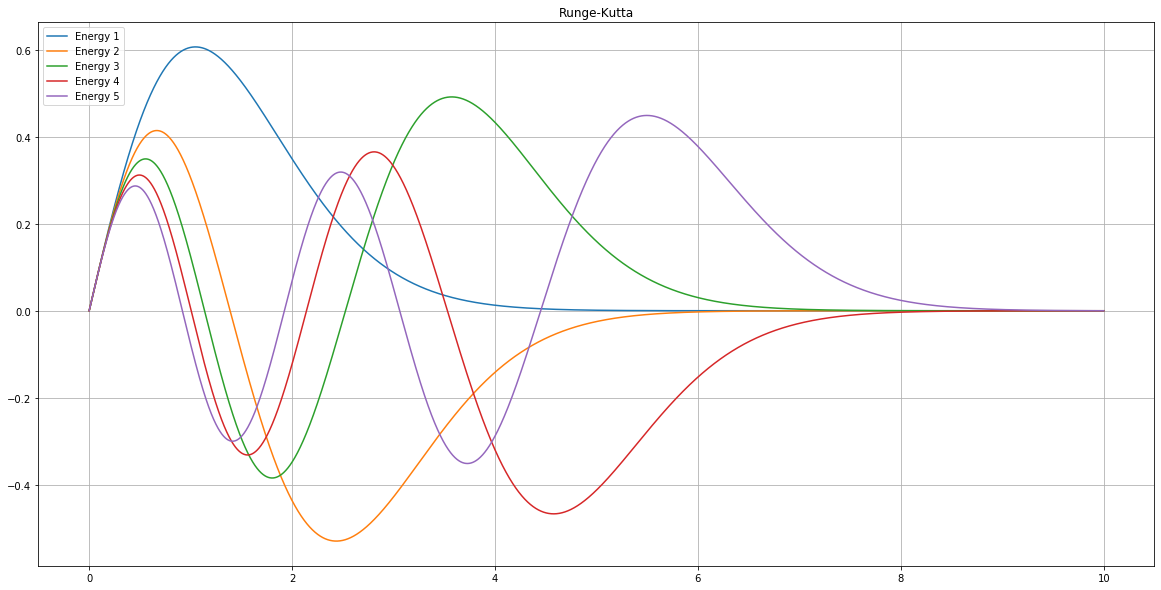

In [13]:
plt.figure(figsize=(20,10))
j = 1;
for E in [root1_rg, root2_rg, root3_rg, root4_rg, root5_rg]:
    # Set initial values
    psi_p = np.zeros([int(n_steps)])
    psi = np.zeros([int(n_steps)])
    psi[0]=0
    psi_p[0]=1
    
    # Perform integration
    for i in range(1,len(x)):
        [psi[i],psi_p[i]] = rungeKutta(x[i-1],psi[i-1],psi_p[i-1],dx,dpsi_pdx,dpsidx,E)
        
    plt.plot(x,psi,label="Energy "+str(j));
    j+=1
    
# Pretty Plot
plt.title("Runge-Kutta")
plt.grid(axis="both")
plt.legend(loc="upper left")
plt.show()